In [1]:
import online_gp
import gpytorch
import torch
import time

In [2]:
from online_gp.models import FixedNoiseOnlineSKIGP
from online_gp.mlls.batched_woodbury_marginal_log_likelihood import BatchedWoodburyMarginalLogLikelihood
from botorch import fit_gpytorch_model

In [3]:
import matplotlib.pyplot as plt

In [4]:
# torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [5]:
train_x = torch.randn(300, 3)
train_y = torch.sin(train_x @ train_x.t()).sum(dim=-1, keepdim=True)

In [6]:
%pdb

Automatic pdb calling has been turned ON


In [7]:
def time_posterior(ntest, nsamples, device, model, dim=3):
    model = model.to(device)
    model.train()
    model.zero_grad()
    
    start = time.time()
    test_x = torch.rand(ntest, dim, device = device, requires_grad=True)
    
    model.eval()
    
    model(test_x).rsample(torch.Size((nsamples,))).norm().backward()  
    end = time.time()
    return end - start
    

In [8]:
nsamples_list = range(100, 15000, 500)

In [9]:
model = FixedNoiseOnlineSKIGP(train_x, train_y, 0.001 * torch.ones_like(train_y), grid_size=15)
model.train()
with gpytorch.settings.use_toeplitz(False):
    fit_gpytorch_model(
        BatchedWoodburyMarginalLogLikelihood(model.likelihood, model, clear_caches_every_iteration=True)
    );

In [10]:
with gpytorch.settings.fast_pred_var(True), gpytorch.settings.fast_pred_samples(False), \
    gpytorch.settings.max_cholesky_size(1000), gpytorch.settings.use_toeplitz(False):
    
    #cpu_fast_pred_var_no_fps = [time_posterior(10000, ns, torch.device("cpu"), model) for ns in nsamples_list]
    
    cuda_fast_pred_var_no_fps = [time_posterior(10000, ns, torch.device("cuda:1"), model) for ns in nsamples_list]

In [11]:
model = FixedNoiseOnlineSKIGP(train_x, train_y, 0.001 * torch.ones_like(train_y), grid_size=15)
model.train()
with gpytorch.settings.use_toeplitz(False):
    fit_gpytorch_model(
        BatchedWoodburyMarginalLogLikelihood(model.likelihood, model, clear_caches_every_iteration=True)
    );

In [12]:
with gpytorch.settings.fast_pred_var(False), gpytorch.settings.fast_pred_samples(False), \
    gpytorch.settings.max_cholesky_size(1000), gpytorch.settings.use_toeplitz(False):
    #cpu_cholesky_no_fps = [time_posterior(10000, ns, torch.device("cpu"), model) for ns in nsamples_list]
    
    cuda_cholesky_no_fps = [time_posterior(10000, ns, torch.device("cuda:1"), model) for ns in nsamples_list]

In [13]:
model = FixedNoiseOnlineSKIGP(train_x, train_y, 0.001 * torch.ones_like(train_y), grid_size=15)
model.train()
with gpytorch.settings.use_toeplitz(False):
    fit_gpytorch_model(
        BatchedWoodburyMarginalLogLikelihood(model.likelihood, model, clear_caches_every_iteration=True)
    );

In [14]:
with gpytorch.settings.fast_pred_var(True), gpytorch.settings.fast_pred_samples(True), \
    gpytorch.settings.max_cholesky_size(100), gpytorch.settings.use_toeplitz(False):
    
    #cpu_fast_pred_var = [time_posterior(10000, ns, torch.device("cpu"), model) for ns in nsamples_list]
    
    cuda_fast_pred_var = [time_posterior(10000, ns, torch.device("cuda:1"), model) for ns in nsamples_list]

In [15]:
model = FixedNoiseOnlineSKIGP(train_x, train_y, 0.001 * torch.ones_like(train_y), grid_size=15)
model.train()
with gpytorch.settings.use_toeplitz(False):
    fit_gpytorch_model(
        BatchedWoodburyMarginalLogLikelihood(model.likelihood, model, clear_caches_every_iteration=True)
    );

In [16]:
with gpytorch.settings.fast_pred_var(False), gpytorch.settings.fast_pred_samples(True), \
    gpytorch.settings.max_cholesky_size(1000), gpytorch.settings.use_toeplitz(False):
    #cpu_cholesky_no_fps = [time_posterior(10000, ns, torch.device("cpu"), model) for ns in nsamples_list]
    
    cuda_cholesky = [time_posterior(10000, ns, torch.device("cuda:1"), model) for ns in nsamples_list]

In [17]:
from botorch.models import FixedNoiseGP
from gpytorch.mlls import ExactMarginalLogLikelihood

exact_model = FixedNoiseGP(train_x, train_y, 0.001 * torch.ones_like(train_y))
fit_gpytorch_model(ExactMarginalLogLikelihood(exact_model.likelihood, exact_model));

In [18]:
with gpytorch.settings.fast_pred_var(True), gpytorch.settings.fast_pred_samples(True), \
    gpytorch.settings.max_cholesky_size(1000):   
    botorch_exact = [time_posterior(10000, ns, torch.device("cuda:1"), exact_model) for ns in nsamples_list]

(0.1, 0.3)

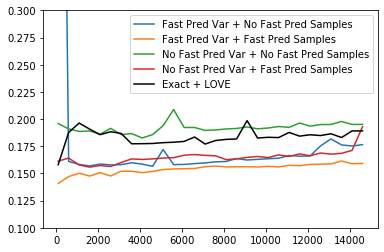

In [19]:
plt.plot(nsamples_list, cuda_fast_pred_var_no_fps, label = "Fast Pred Var + No Fast Pred Samples")
plt.plot(nsamples_list, cuda_fast_pred_var, label = "Fast Pred Var + Fast Pred Samples")
plt.plot(nsamples_list, cuda_cholesky_no_fps, label = "No Fast Pred Var + No Fast Pred Samples")
plt.plot(nsamples_list, cuda_cholesky, label = "No Fast Pred Var + Fast Pred Samples")
plt.plot(nsamples_list, botorch_exact, color = "black", label = "Exact + LOVE")
plt.legend()

plt.ylim((0.1, 0.3))